# Data Exploration

ET and EEG feature comparison between Normal Reading (NR) and Task Specific Reading (TSR) / Annotation Reading (AR) for [ZuCo](https://osf.io/q3zws/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import gzip
import math
import matplotlib
import os
import random
import re
import scipy

from collections import defaultdict
from scipy.stats import pearsonr, ttest_rel
from plot_funcs import *
from utils import *

In [2]:
sns.set()

## Eye-Tracking (ET)

In [7]:
# instantiate data transformer object for task 1, 2, or 3 on sentence level (no scaling for now)
datatransform_t1_et_word = DataTransformer('task1', level='word', data='ET', scaling='min-max', fillna='min')
datatransform_t2_et_word = DataTransformer('task2', level='word', data='ET', scaling='min-max', fillna='min')
datatransform_t3_et_word = DataTransformer('task3', level='word', data='ET', scaling='min-max', fillna='min')

In [89]:
# instantiate data transformer object for task 1, 2, or 3 on sentence level (no scaling for now)
datatransform_t1_et_sent = DataTransformer('task1', level='sentence', data='ET', scaling='raw', fillna='zeros')
datatransform_t2_et_sent = DataTransformer('task2', level='sentence', data='ET', scaling='raw', fillna='zeros')
datatransform_t3_et_sent = DataTransformer('task3', level='sentence', data='ET', scaling='raw', fillna='zeros')

In [8]:
# get data for all subjects according to settings specified in cell above
# NOTE: data for each sbj will be stored in pd.DataFrame
sbjs_t1_et_word = [datatransform_t1_et_word(i) for i in range(12)]
sbjs_t2_et_word = [datatransform_t2_et_word(i) for i in range(12)]
sbjs_t3_et_word = [datatransform_t3_et_word(i) for i in range(12)]

In [ ]:
# get data for all subjects according to settings specified in cell above
# NOTE: data for each sbj will be stored in pd.DataFrame
sbjs_t1_et_sent = [datatransform_t1_et_sent(i) for i in range(12)]
sbjs_t2_et_sent = [datatransform_t2_et_sent(i) for i in range(12)]
sbjs_t3_et_sent = [datatransform_t3_et_sent(i) for i in range(12)]

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Lukas\Documents\GitHub\NER-with-EEG-and-ET\utils.py:202: RuntimeWarning: invalid value encountered in true_divide
  features[idx, start_et:-1] /= n_words_fixated


In [5]:
# for each dataset check whether data is complete and transformation was performed correctly
for i, (sbj_t1, sbj_t2, sbj_t3) in enumerate(zip(sbjs_t1_et, sbjs_t2_et, sbjs_t3_et)):
    print("Subject:", i+1)
    print()
    print("Number of sents for task 1: ", len(sbj_t1))
    print("Number of sents for task 2: ", len(sbj_t2))
    print("Number of sents for task 3: ", len(sbj_t3))
    print()

Subject: 1

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 2

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 3

Number of sents for task 1:  299
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 4

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  360

Subject: 5

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 6

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 7

Number of sents for task 1:  400
Number of sents for task 2:  250
Number of sents for task 3:  407

Subject: 8

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  359

Subject: 9

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3

### Eye-Tracking feature comparison between first and second half of Task 1 (NR)

First and second half of Task 1 (NR Sentiment) have to be compared to inspect whether an order effect has to be reported

In [6]:
# split data into first and second half
first_half, second_half = split_data(sbjs_t1_et)

In [7]:
# check whether data splitting was performed correctly
#for i, (first, second) in enumerate(zip(first_half, second_half)):
#    print("Subject:", i)
#    print()
#    print("Number of sents in first half:", len(first))
#    print("Number of sents in second half:", len(second))
#    print()

In [21]:
# compute mean values per sbj per feature for first and second half
sentlen_t1_m1, wordlen_t1_m1, omissions_t1_m1, fixations_t1_m1, pupilsize_t1_m1, gd_t1_m1, trt_t1_m1, ffd_t1_m1, gpt_t1_m1, bncfreq_t1_m1 = compute_means(first_half, features='ET')
sentlen_t1_m2, wordlen_t1_m2, omissions_t1_m2, fixations_t1_m2, pupilsize_t1_m2, gd_t1_m2, trt_t1_m2, ffd_t1_m2, gpt_t1_m2, bncfreq_t1_m2 = compute_means(second_half, features='ET')

In [28]:
# compute all vals per sbj for first and second half to test for order effects
sentlen_t1_all1, wordlen_t1_all1, omissions_t1_all1, fixations_t1_all1, pupilsize_t1_all1, gd_t1_all1, trt_t1_all1, ffd_t1_all1, gpt_t1_all1, bncfreq_t1_all1 = compute_allvals(first_half, features='ET')
sentlen_t1_all2, wordlen_t1_all2, omissions_t1_all2, fixations_t1_all2, pupilsize_t1_all2, gd_t1_all2, trt_t1_all2, ffd_t1_all2, gpt_t1_all2, bncfreq_t1_all2 = compute_allvals(second_half, features='ET')

In [23]:
sentlen_t1, wordlen_t1, omissions_t1, fixations_t1, pupilsize_t1, gd_t1, trt_t1, ffd_t1, gpt_t1, bncfreq_t1 = compute_allvals(sbjs_t1_et, features='ET')

In [24]:
corr_mat(compute_allvals(sbjs_t1_et, features='ET'), features='ET', heatmap=False)

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,-0.207487,0.176827,-0.249376,-0.042790,-0.210575,-0.316053,-0.155814,-0.282738,0.270083
MeanWordLen,-0.207487,1.000000,-0.270190,0.237504,-0.012421,0.292752,0.257303,0.108762,0.172753,-0.638324
omissionRate,0.176827,-0.270190,1.000000,-0.174083,0.027624,-0.099252,-0.202164,-0.180843,-0.181258,0.247578
nFixations,-0.249376,0.237504,-0.174083,1.000000,-0.036620,0.389100,0.923867,0.075564,0.843443,-0.240436
meanPupilSize,-0.042790,-0.012421,0.027624,-0.036620,1.000000,-0.014922,-0.046394,-0.014921,-0.039271,-0.007651
GD,-0.210575,0.292752,-0.099252,0.389100,-0.014922,1.000000,0.565322,0.621009,0.421198,-0.279252
TRT,-0.316053,0.257303,-0.202164,0.923867,-0.046394,0.565322,1.000000,0.353175,0.889270,-0.262502
FFD,-0.155814,0.108762,-0.180843,0.075564,-0.014921,0.621009,0.353175,1.000000,0.283641,-0.110249
GPT,-0.282738,0.172753,-0.181258,0.843443,-0.039271,0.421198,0.889270,0.283641,1.000000,-0.189415
BNCFreq,0.270083,-0.638324,0.247578,-0.240436,-0.007651,-0.279252,-0.262502,-0.110249,-0.189415,1.000000


In [104]:
all_sbjs_t1_et = pd.concat(sbjs_t1_et)

In [17]:
all_sbjs_t1_et_word = pd.concat(sbjs_t1_et_word)
all_sbjs_t2_et_word = pd.concat(sbjs_t2_et_word)
all_sbjs_t3_et_word = pd.concat(sbjs_t3_et_word)

In [88]:
all_sbjs_t1_et_sent = pd.concat(sbjs_t1_et)
all_sbjs_t2_et_sent = pd.concat(sbjs_t2_et)
all_sbjs_t3_et_sent = pd.concat(sbjs_t3_et)

NameError: name 'sbjs_t1_et' is not defined

In [19]:
all_sbjs_t2_et_word['Task'] = 'NR'
all_sbjs_t3_et_word['Task'] = 'TSR'

In [77]:
all_sbjs_both_tasks_et_word = pd.concat([all_sbjs_t2_et_word, all_sbjs_t3_et_word])

In [78]:
del all_sbjs_both_tasks_et_word['Sent_ID']
del all_sbjs_both_tasks_et_word['Word_ID']
del all_sbjs_both_tasks_et_word['Word']

In [79]:
all_sbjs_both_tasks_et_word = all_sbjs_both_tasks_et_word.apply(lambda col: col.to_numpy().ravel(), axis=0)

In [73]:
all_sbjs_both_tasks_et_word = all_sbjs_both_tasks_et_word.apply(lambda col: col.values.reshape(-1), axis=0)

In [81]:
all_sbjs_both_tasks_et_word.head()

,nFixations,meanPupilSize,GD,TRT,FFD,GPT,WordLen,BNCFreq,Task
0,0.1250,0.863905,0.076613,0.079350,0.245478,0.029743,0.16,0.849432,NR
1,0.0625,0.889265,0.080645,0.047801,0.258398,0.031309,0.12,0.822132,NR
2,0.1250,0.889687,0.076613,0.069790,0.245478,0.099249,0.32,0.637862,NR
3,0.0625,0.936602,0.078226,0.046367,0.250646,0.030369,0.08,0.920403,NR
4,0.0625,0.919696,0.083065,0.049235,0.266150,0.032248,0.16,0.554629,NR


ValueError: could not broadcast input array from shape (172712,1) into shape (172712)

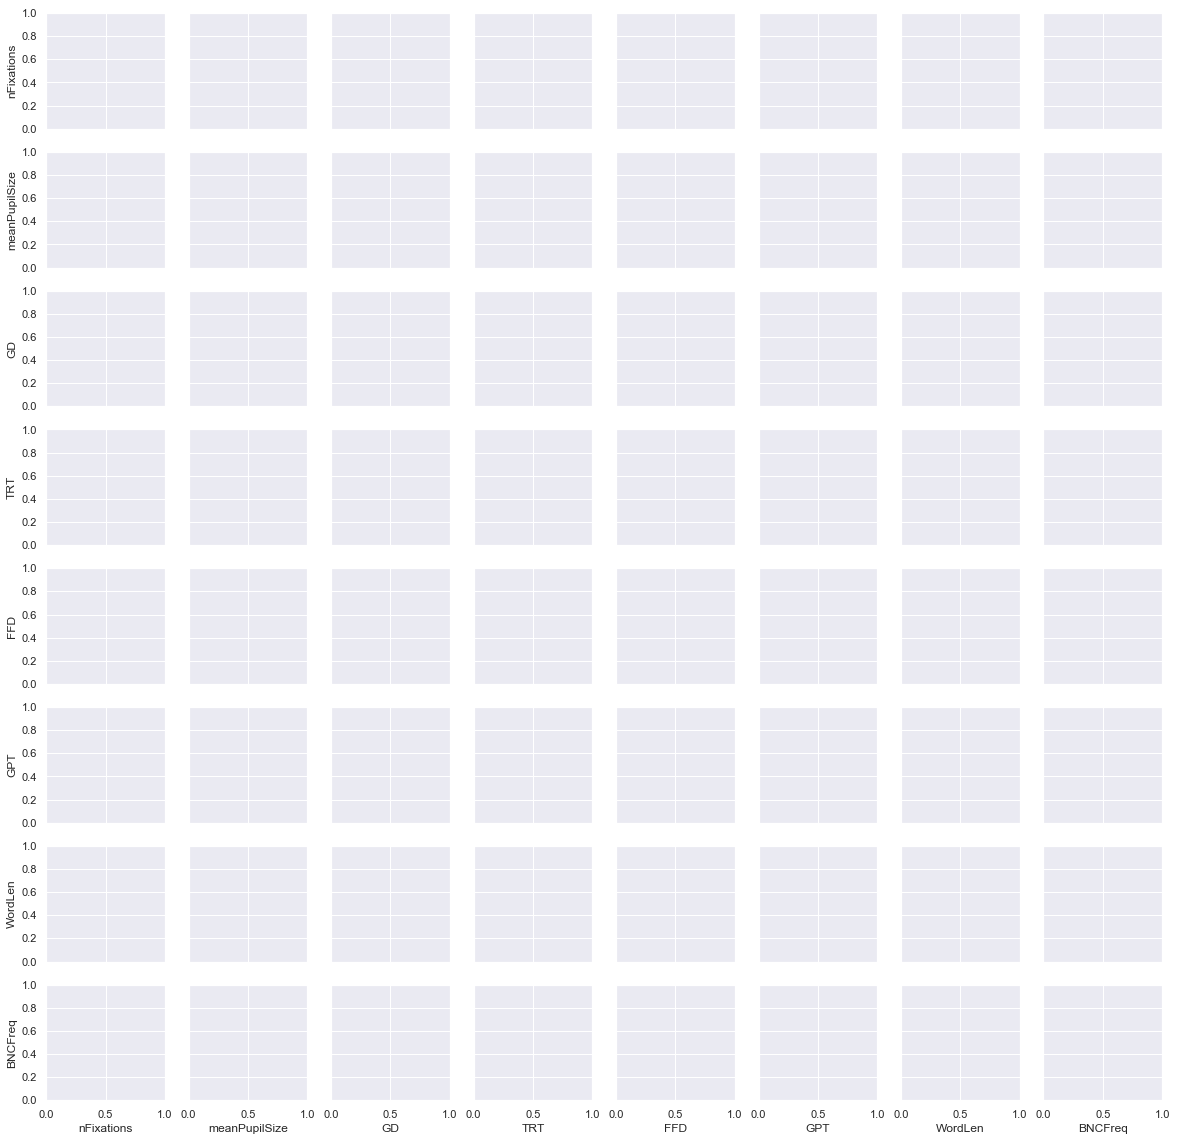

In [83]:
g = sns.PairGrid(all_sbjs_both_tasks_et_word, vars=['nFixations','meanPupilSize',
                'GD','TRT','FFD','GPT','WordLen','BNCFreq'], hue='Task', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

In [13]:
all_sbjs_t1_et_word.head()

,Sent_ID,Word_ID,Word,nFixations,meanPupilSize,GD,TRT,FFD,GPT,WordLen,BNCFreq
0,0_NR,0,presents,0.333333,0.771470,0.113225,0.569847,0.185647,0.036358,0.380952,0.499857
1,0_NR,1,a,0.250000,0.780897,0.069458,0.251278,0.113885,0.258173,0.047619,0.932427
2,0_NR,2,good,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190476,0.722573
3,0_NR,3,case,0.083333,0.836499,0.100856,0.090290,0.165367,0.032386,0.190476,0.682662
4,0_NR,4,while,0.250000,0.793559,0.316841,0.283646,0.226209,0.101742,0.238095,0.699861


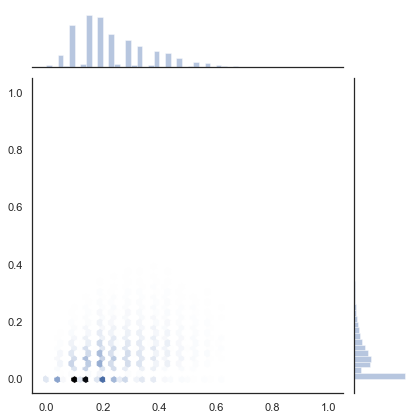

In [87]:
with sns.axes_style('white'):
    sns.jointplot("WordLen", "TRT", all_sbjs_t1_et_word, kind='hex')

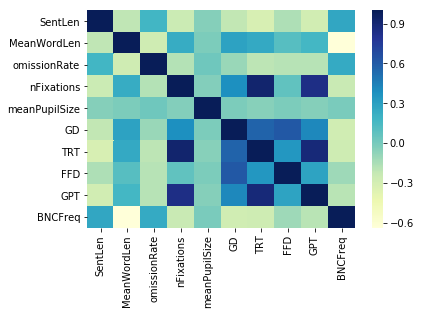

In [25]:
corr_mat(compute_allvals(sbjs_t1_et, features='ET'), features='ET', heatmap=True)

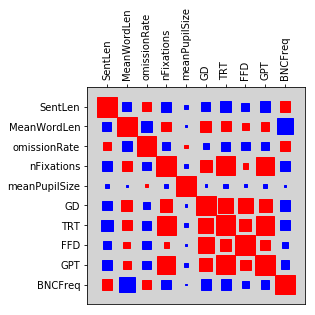

In [58]:
corr_mat(compute_allvals(sbjs_t1_et, features='ET'), features='ET', hinton_mat=True)

#### Mean fixations per word per subject

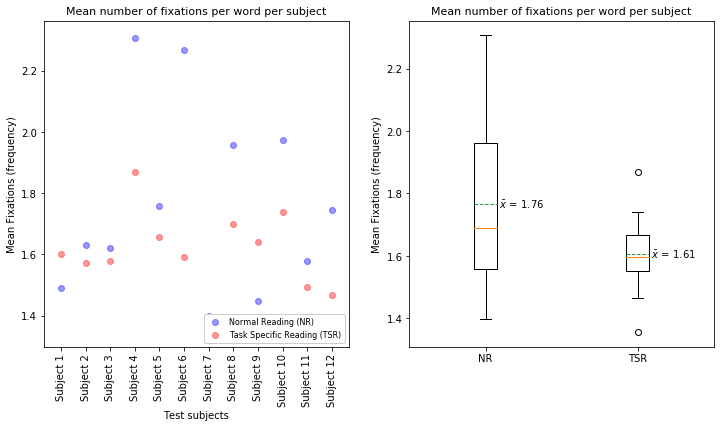

p-value: 8.993791728575665e-14


In [29]:
plot_fix(fixations_t1_m1, fixations_t1_m2)
print("p-value:", randomsample_paired_ttest(fixations_t1_all1, fixations_t1_all2))

#### Omission rate on sentence level

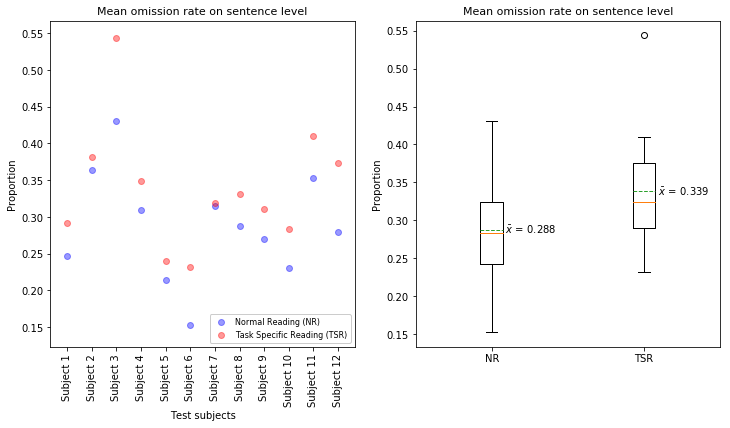

p-value: 2.506964486554318e-18


In [30]:
plot_omissions(omissions_t1_m1, omissions_t1_m2)
print("p-value:", randomsample_paired_ttest(omissions_t1_all1, omissions_t1_all2))

#### Mean GD per word per subject

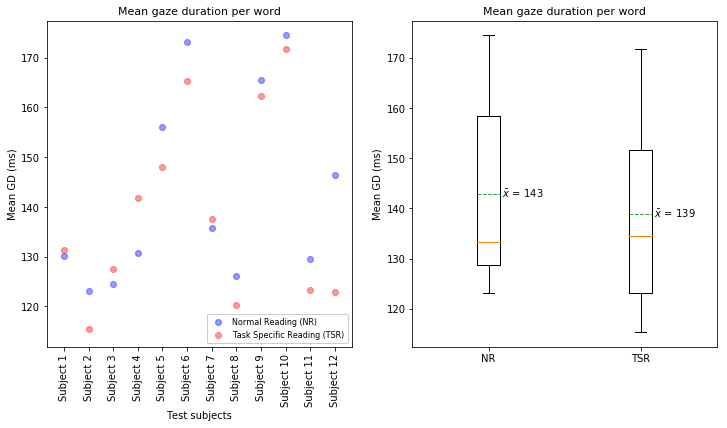

p-value: 0.01983581876392412


In [31]:
plot_gd(gd_t1_m1, gd_t1_m2)
print("p-value:", randomsample_paired_ttest(gd_t1_all1, gd_t1_all2))

#### Mean TRT per word per subject

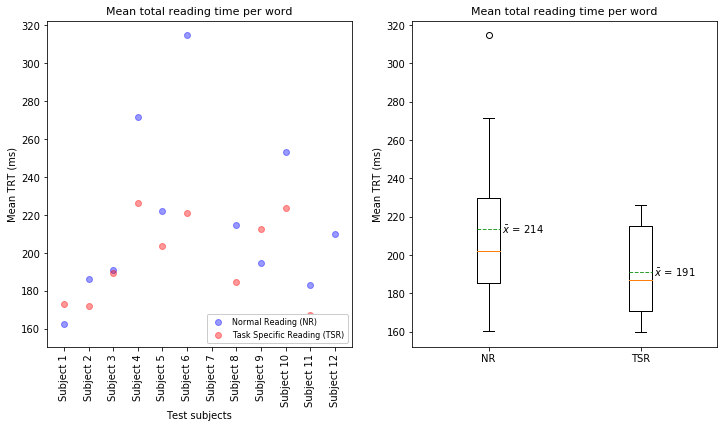

p-value: 3.452431664198112e-14


In [32]:
plot_trt(trt_t1_m1, trt_t1_m2)
print("p-value:", randomsample_paired_ttest(trt_t1_all1, trt_t1_all2))

#### Mean FFD per word per subject

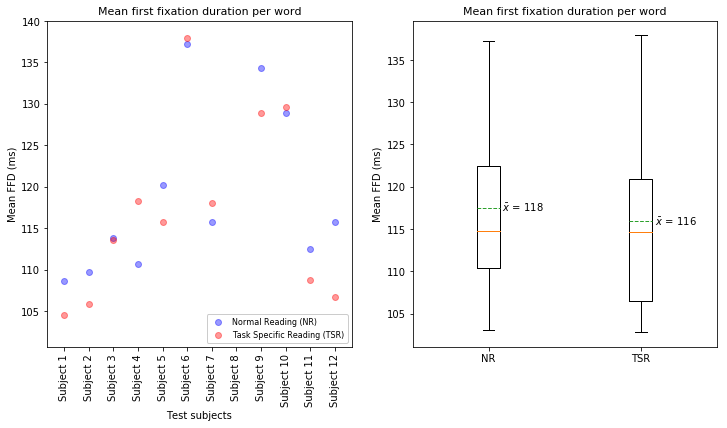

p-value: 0.2024933600598719


In [33]:
plot_ffd(ffd_t1_m1, ffd_t1_m2)
print("p-value:", randomsample_paired_ttest(ffd_t1_all1, ffd_t1_all2))

### Eye-Tracking feature comparison between Task 2 (NR) and Task 3 (TSR)

In [35]:
sentlen_m_t2, wordlen_m_t2, omissions_m_t2, fixations_m_t2, pupilsize_m_t2, gd_m_t2, trt_m_t2, ffd_m_t2, gpt_m_t2, bncfreq_m_t2 = compute_means(sbjs_t2_et, features='ET')
sentlen_m_t3, wordlen_m_t3, omissions_m_t3, fixations_m_t3, pupilsize_m_t3, gd_m_t3, trt_m_t3, ffd_m_t3, gpt_m_t3, bncfreq_m_t3 = compute_means(sbjs_t3_et, features='ET')

In [36]:
sentlens_t2, wordlens_t2, omissions_t2, fixations_t2, pupilsize_t2, gd_t2, trt_t2, ffd_t2, gpt_t2, bnc_freqs_t2 = compute_allvals(sbjs_t2_et, features='ET')
sentlens_t3, wordlens_t3, omissions_t3, fixations_t3, pupilsize_t3, gd_t3, trt_t3, ffd_t3, gpt_t3, bnc_freqs_t3 = compute_allvals(sbjs_t3_et, features='ET')

In [40]:
corr_mat(compute_allvals(sbjs_t2_et, features='ET'), features='ET')

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,0.092248,0.040784,-0.102107,-0.041531,-0.077621,-0.149289,-0.059944,-0.135942,0.085329
MeanWordLen,0.092248,1.000000,-0.140128,0.089848,-0.023629,0.107874,0.066725,-0.010725,0.026757,-0.090237
omissionRate,0.040784,-0.140128,1.000000,-0.294206,0.002062,-0.255537,-0.337702,-0.300276,-0.293148,0.098750
nFixations,-0.102107,0.089848,-0.294206,1.000000,0.019607,0.434918,0.928690,0.198415,0.830028,-0.141851
meanPupilSize,-0.041531,-0.023629,0.002062,0.019607,1.000000,0.085075,0.048578,0.139681,0.009082,0.022109
GD,-0.077621,0.107874,-0.255537,0.434918,0.085075,1.000000,0.618623,0.694371,0.481751,-0.079906
TRT,-0.149289,0.066725,-0.337702,0.928690,0.048578,0.618623,1.000000,0.450090,0.881029,-0.143088
FFD,-0.059944,-0.010725,-0.300276,0.198415,0.139681,0.694371,0.450090,1.000000,0.385659,-0.024958
GPT,-0.135942,0.026757,-0.293148,0.830028,0.009082,0.481751,0.881029,0.385659,1.000000,-0.140980
BNCFreq,0.085329,-0.090237,0.098750,-0.141851,0.022109,-0.079906,-0.143088,-0.024958,-0.140980,1.000000


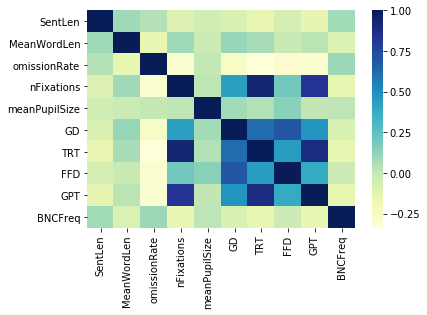

In [46]:
corr_mat(compute_allvals(sbjs_t2_et, features='ET'), features='ET', heatmap=True, mask=False)

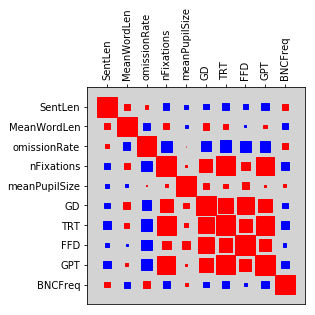

In [45]:
corr_mat(compute_allvals(sbjs_t2_et, features='ET'), features='ET', heatmap=False, mask=False, hinton_mat=True)

In [47]:
corr_mat(compute_allvals(sbjs_t3_et, features='ET'), features='ET')

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,GD,TRT,FFD,GPT,BNCFreq
SentLen,1.000000,0.027612,0.213212,-0.081536,-0.046910,-0.080330,-0.133258,-0.122483,-0.111039,-0.137217
MeanWordLen,0.027612,1.000000,-0.144142,0.126453,-0.008896,0.084175,0.090698,0.010286,0.050217,-0.259845
omissionRate,0.213212,-0.144142,1.000000,-0.319906,-0.109924,-0.276460,-0.362526,-0.302798,-0.314289,-0.159095
nFixations,-0.081536,0.126453,-0.319906,1.000000,0.024687,0.364939,0.886269,0.152742,0.754772,-0.015669
meanPupilSize,-0.046910,-0.008896,-0.109924,0.024687,1.000000,-0.028278,-0.017986,0.014899,-0.018091,0.011660
GD,-0.080330,0.084175,-0.276460,0.364939,-0.028278,1.000000,0.611637,0.776320,0.447338,-0.048618
TRT,-0.133258,0.090698,-0.362526,0.886269,-0.017986,0.611637,1.000000,0.469694,0.830373,-0.011053
FFD,-0.122483,0.010286,-0.302798,0.152742,0.014899,0.776320,0.469694,1.000000,0.375479,-0.002125
GPT,-0.111039,0.050217,-0.314289,0.754772,-0.018091,0.447338,0.830373,0.375479,1.000000,0.013267
BNCFreq,-0.137217,-0.259845,-0.159095,-0.015669,0.011660,-0.048618,-0.011053,-0.002125,0.013267,1.000000


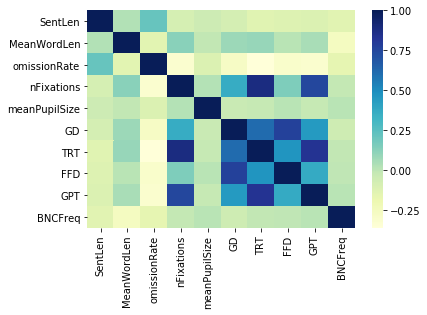

In [49]:
corr_mat(compute_allvals(sbjs_t3_et, features='ET'), features='ET',  heatmap=True)

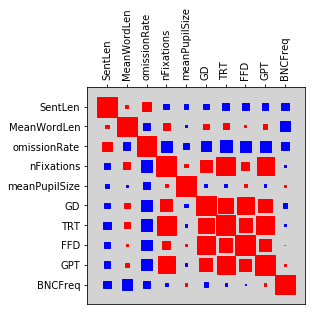

In [52]:
corr_mat(compute_allvals(sbjs_t3_et, features='ET'), features='ET',  heatmap=False, mask=False, hinton_mat=True)

#### Mean fixations per word per subject

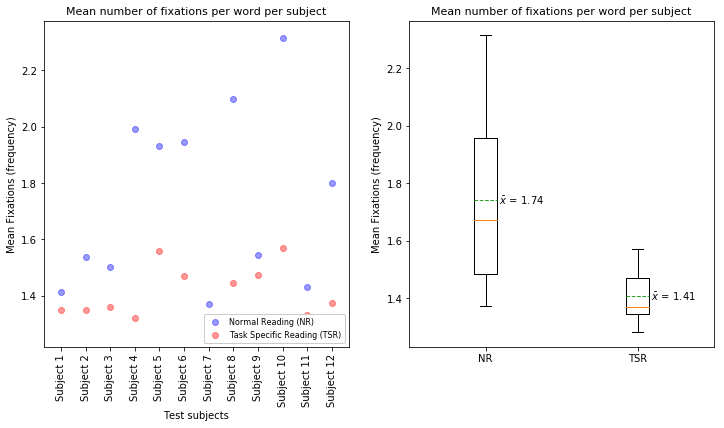

p-value: 1.2039742262066416e-83


In [53]:
plot_fix(fixations_m_t2, fixations_m_t3)
print("p-value:", randomsample_paired_ttest(fixations_t2, fixations_t3))

#### Omission rate on sentence level

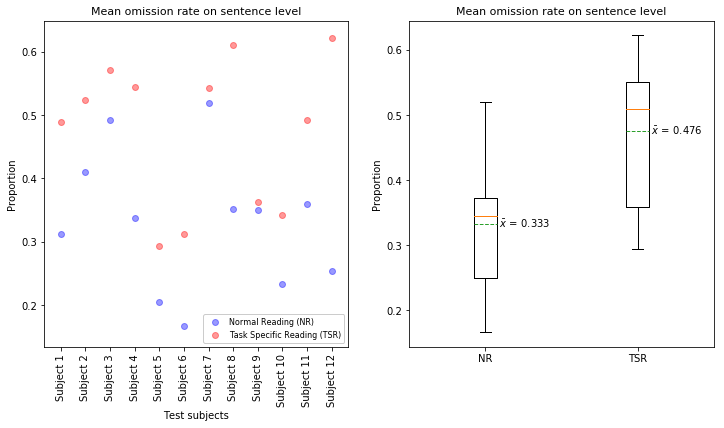

p-value: 7.070340030115888e-102


In [54]:
plot_omissions(omissions_m_t2, omissions_m_t3)
print("p-value:", randomsample_paired_ttest(omissions_t2, omissions_t3))

#### Mean GD per word per subject

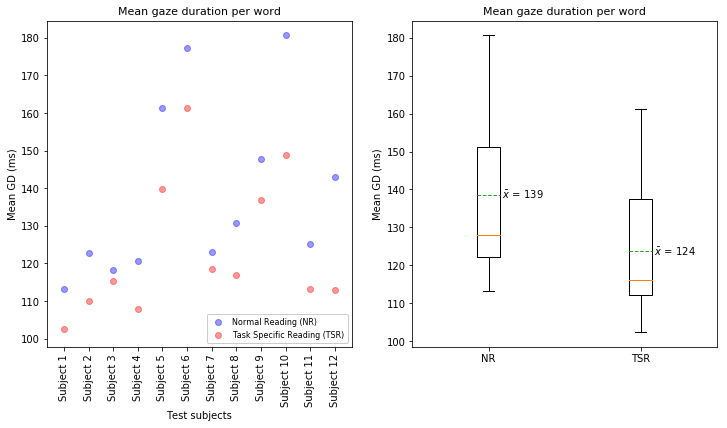

p-value: 5.363504861628482e-31


In [55]:
plot_gd(gd_m_t2, gd_m_t3)
print("p-value:", randomsample_paired_ttest(gd_t2, gd_t3))

#### Mean TRT per word per subject

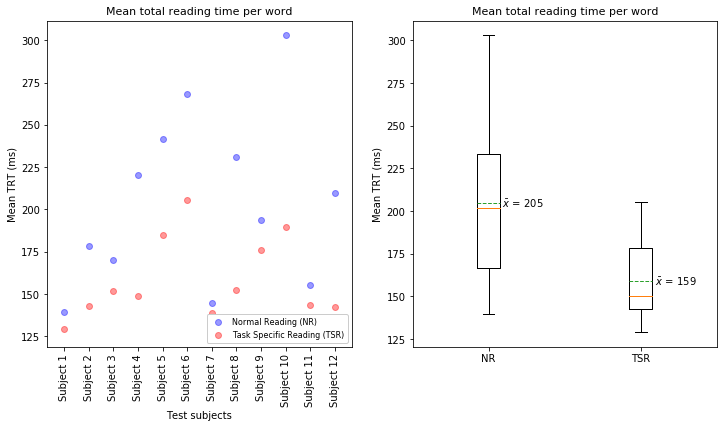

p-value: 1.738141148789982e-80


In [56]:
plot_trt(trt_m_t2, trt_m_t3)
print("p-value:", randomsample_paired_ttest(trt_t2, trt_t3))

#### Mean FFD per word per subject

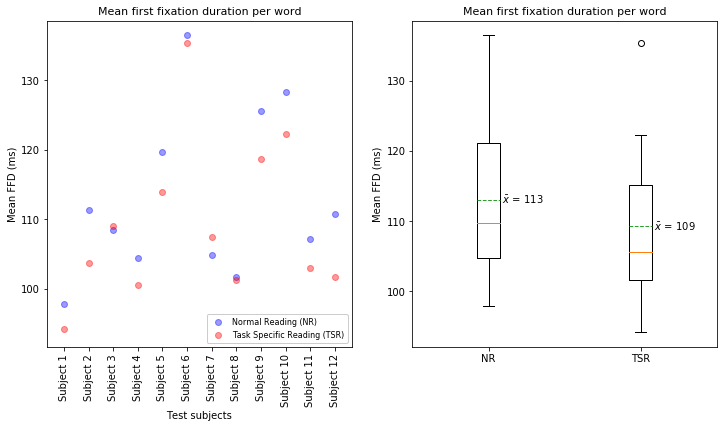

p-value: 4.36931403332046e-07


In [57]:
plot_ffd(ffd_m_t2, ffd_m_t3)
print("p-value:", randomsample_paired_ttest(ffd_t2, ffd_t3))

## EEG 

In [66]:
# instantiate data transformer object for task 1, 2, or 3 on sentence level (no scaling for now)
datatransform_t1_eeg = DataTransformer('task1', level='sentence', data='EEG', scaling='raw', fillna='zeros')
datatransform_t2_eeg = DataTransformer('task2', level='sentence', data='EEG', scaling='raw', fillna='zeros')
datatransform_t3_eeg = DataTransformer('task3', level='sentence', data='EEG', scaling='raw', fillna='zeros')

In [67]:
# get data for all subjects according to settings specified in cell above
# NOTE: data for each sbj will be stored in pd.DataFrame
sbjs_t1_eeg = [datatransform_t1_eeg(i) for i in range(12)]
sbjs_t2_eeg = [datatransform_t2_eeg(i) for i in range(12)]
sbjs_t3_eeg = [datatransform_t3_eeg(i) for i in range(12)]

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Lukas\Documents\GitHub\NER-with-EEG-and-ET\utils.py:201: RuntimeWarning: invalid value encountered in true_divide
  features[idx, start_et:-1] /= n_words_fixated


In [68]:
# for each dataset check whether data is complete and transformation was performed correctly
for i, (sbj_t1, sbj_t2, sbj_t3) in enumerate(zip(sbjs_t1_eeg, sbjs_t2_eeg, sbjs_t3_eeg)):
    print("Subject:", i+1)
    print()
    print("Number of sents for task 1: ", len(sbj_t1))
    print("Number of sents for task 2: ", len(sbj_t2))
    print("Number of sents for task 3: ", len(sbj_t3))
    print()

Subject: 1

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 2

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 3

Number of sents for task 1:  299
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 4

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  360

Subject: 5

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 6

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  407

Subject: 7

Number of sents for task 1:  400
Number of sents for task 2:  250
Number of sents for task 3:  407

Subject: 8

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3:  359

Subject: 9

Number of sents for task 1:  400
Number of sents for task 2:  300
Number of sents for task 3

### EEG feature comparison between first and second half of Task 1 (NR)

First and second half of Task 1 (NR Sentiment) have to be compared to inspect whether an order effect has to be reported

In [69]:
# split data into first and second half
first_half, second_half = split_data(sbjs_t1_eeg)

In [70]:
sentlen_t1_m1, wordlen_t1_m1, omissions_t1_m1, fixations_t1_m1, pupilsize_t1_m1, mean_theta_t1_m1, mean_alpha_t1_m1, mean_beta_t1_m1, mean_gamma_t1_m1, bncfreq_t1_m1 = compute_means(first_half, features='EEG')
sentlen_t1_m2, wordlen_t1_m2, omissions_t1_m2, fixations_t1_m2, pupilsize_t1_m2, mean_theta_t1_m2, mean_alpha_t1_m2, mean_beta_t1_m2, mean_gamma_t1_m2, bncfreq_t1_m2 = compute_means(second_half, features='EEG')

In [71]:
sentlen_t1_all1, wordlen_t1_all1, omissions_t1_all1, fixations_t1_all1, pupilsize_t1_all1, mean_theta_t1_all1, mean_alpha_t1_all1, mean_beta_t1_all1, mean_gamma_t1_all1, bncfreq_t1_all1 = compute_allvals(first_half, features='EEG')
sentlen_t1_all2, wordlen_t1_all2, omissions_t1_all2, fixations_t1_all2, pupilsize_t1_all2, mean_theta_t1_all2, mean_alpha_t1_all2, mean_beta_t1_all2, mean_gamma_t1_all2, bncfreq_t1_all2 = compute_allvals(second_half, features='EEG')

In [72]:
sentlens_t1, wordlens_t1, omissions_t1, fixations_t1, pupilsize_t1, mean_theta_t1, mean_alpha_t1, mean_beta_t1, mean_gamma_t1, bnc_freqs_t1 = compute_allvals(sbjs_t1_eeg, features='EEG')

In [73]:
corr_mat(compute_allvals(sbjs_t1_eeg, features='EEG'), features='EEG', heatmap=False)

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,mean_theta,mean_alpha,mean_beta,mean_gamma,BNCFreq
SentLen,1.000000,-0.207487,0.176827,-0.249376,-0.042790,0.007202,0.022773,-0.003959,-0.034996,0.270083
MeanWordLen,-0.207487,1.000000,-0.270190,0.237504,-0.012421,-0.007430,0.000168,-0.004350,0.001907,-0.638324
omissionRate,0.176827,-0.270190,1.000000,-0.174083,0.027624,0.127837,0.086582,0.079320,0.027823,0.247578
nFixations,-0.249376,0.237504,-0.174083,1.000000,-0.036620,-0.055293,-0.100290,-0.084113,-0.113916,-0.240436
meanPupilSize,-0.042790,-0.012421,0.027624,-0.036620,1.000000,-0.069274,0.087452,0.168051,0.166080,-0.007651
mean_theta,0.007202,-0.007430,0.127837,-0.055293,-0.069274,1.000000,0.917975,0.886223,0.705994,0.007811
mean_alpha,0.022773,0.000168,0.086582,-0.100290,0.087452,0.917975,1.000000,0.948847,0.774056,0.011273
mean_beta,-0.003959,-0.004350,0.079320,-0.084113,0.168051,0.886223,0.948847,1.000000,0.834656,0.005423
mean_gamma,-0.034996,0.001907,0.027823,-0.113916,0.166080,0.705994,0.774056,0.834656,1.000000,-0.003006
BNCFreq,0.270083,-0.638324,0.247578,-0.240436,-0.007651,0.007811,0.011273,0.005423,-0.003006,1.000000


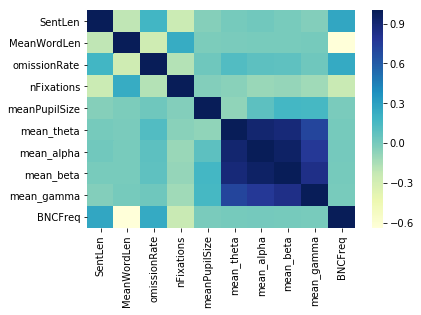

In [74]:
corr_mat(compute_allvals(sbjs_t1_eeg, features='EEG'), features='EEG', heatmap=True)

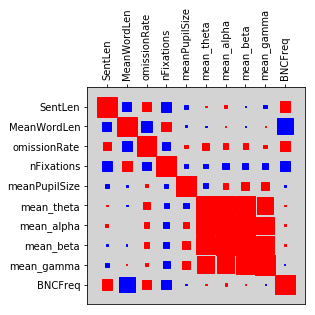

In [77]:
corr_mat(compute_allvals(sbjs_t1_eeg, features='EEG'), features='EEG', hinton_mat=True)

#### Mean EEG activity (theta) per sentence per subject

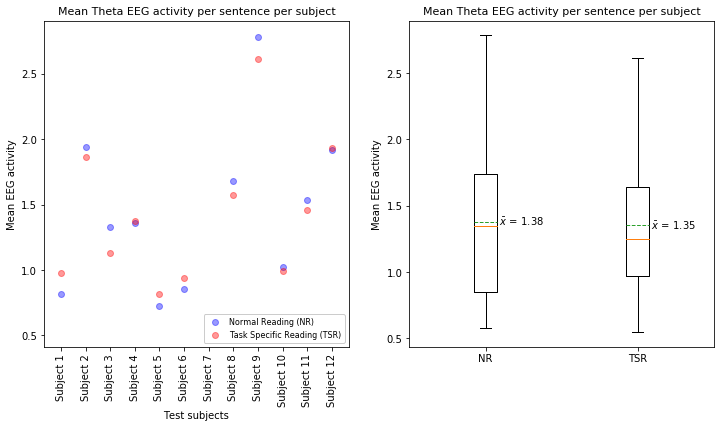

p-value: 0.296399778512416


In [78]:
plot_eeg(mean_theta_t1_m1, mean_theta_t1_m2, 'theta')
print("p-value:", randomsample_paired_ttest(mean_theta_t1_all1, mean_theta_t1_all2))

#### Mean EEG activity (alpha) per sentence per subject

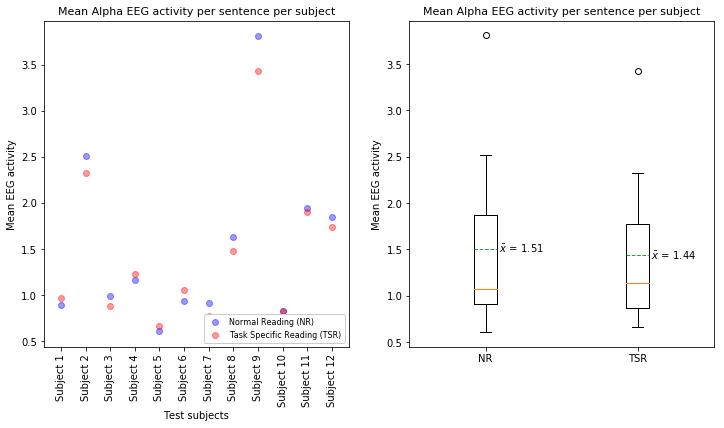

p-value: 0.07385487926149775


In [79]:
plot_eeg(mean_alpha_t1_m1, mean_alpha_t1_m2, 'alpha')
print("p-value:", randomsample_paired_ttest(mean_alpha_t1_all1, mean_alpha_t1_all2))

#### Mean EEG activity (beta) per sentence per subject

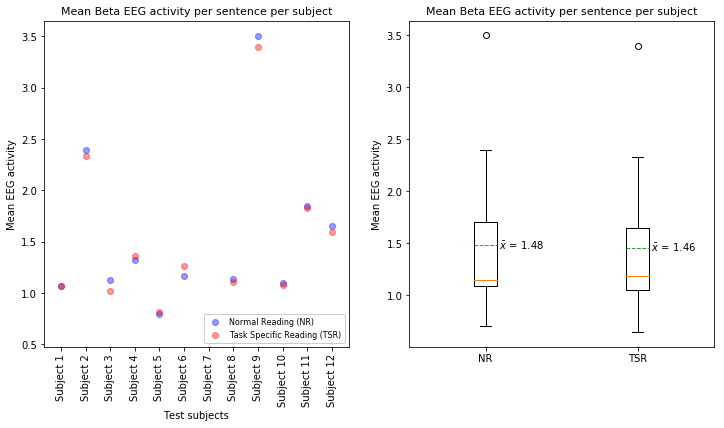

p-value: 0.3984270330856349


In [80]:
plot_eeg(mean_beta_t1_m1, mean_beta_t1_m2, 'beta')
print("p-value:", randomsample_paired_ttest(mean_beta_t1_all1, mean_beta_t1_all2))

#### Mean EEG activity (gamma) per sentence per subject

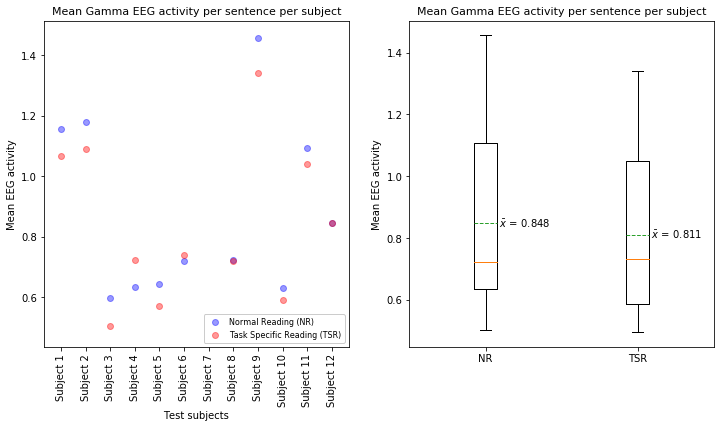

p-value: 0.01975876810422904


In [81]:
plot_eeg(mean_gamma_t1_m1, mean_gamma_t1_m2, 'gamma')
print("p-value:", randomsample_paired_ttest(mean_gamma_t1_all1, mean_gamma_t1_all2))

### EEG feature comparison between Task 2 (NR) and Task 3 (TSR)

In [82]:
sentlen_t2_m, wordlen_t2_m, omissions_t2_m, fixations_t2_m, pupilsize_t2_m, mean_theta_t2_m, mean_alpha_t2_m, mean_beta_t2_m, mean_gamma_t2_m, bncfreq_t2_m = compute_means(sbjs_t2_eeg, features='EEG')
sentlen_t3_m, wordlen_t3_m, omissions_t3_m, fixations_t3_m, pupilsize_t3_m, mean_theta_t3_m, mean_alpha_t3_m, mean_beta_t3_m, mean_gamma_t3_m, bncfreq_t3_m = compute_means(sbjs_t3_eeg, features='EEG')

In [83]:
sentlen_t2, wordlen_t2, omissions_t2, fixations_t2, pupilsize_t2, mean_theta_t2, mean_alpha_t2, mean_beta_t2, mean_gamma_t2, bncfreqs_t2 = compute_allvals(sbjs_t2_eeg, features='EEG')
sentlen_t3, wordlen_t3, omissions_t3, fixations_t3, pupilsize_t3, mean_theta_t3, mean_alpha_t3, mean_beta_t3, mean_gamma_t3, bncfreqs_t3 = compute_allvals(sbjs_t3_eeg, features='EEG')

In [84]:
corr_mat(compute_allvals(sbjs_t2_eeg, features='EEG'), features='EEG', heatmap=False)

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,mean_theta,mean_alpha,mean_beta,mean_gamma,BNCFreq
SentLen,1.000000,0.092248,0.040784,-0.102107,-0.041531,-0.016323,-0.004113,-0.019793,-0.035269,0.085329
MeanWordLen,0.092248,1.000000,-0.140128,0.089848,-0.023629,-0.001313,0.005182,-0.004749,-0.003199,-0.090237
omissionRate,0.040784,-0.140128,1.000000,-0.294206,0.002062,0.091569,0.116410,0.068196,-0.012154,0.098750
nFixations,-0.102107,0.089848,-0.294206,1.000000,0.019607,-0.105187,-0.188393,-0.170081,-0.207264,-0.141851
meanPupilSize,-0.041531,-0.023629,0.002062,0.019607,1.000000,-0.088924,0.122518,0.189083,0.169256,0.022109
mean_theta,-0.016323,-0.001313,0.091569,-0.105187,-0.088924,1.000000,0.898190,0.876360,0.678349,0.007473
mean_alpha,-0.004113,0.005182,0.116410,-0.188393,0.122518,0.898190,1.000000,0.952882,0.752146,0.021311
mean_beta,-0.019793,-0.004749,0.068196,-0.170081,0.189083,0.876360,0.952882,1.000000,0.822063,0.011688
mean_gamma,-0.035269,-0.003199,-0.012154,-0.207264,0.169256,0.678349,0.752146,0.822063,1.000000,-0.019229
BNCFreq,0.085329,-0.090237,0.098750,-0.141851,0.022109,0.007473,0.021311,0.011688,-0.019229,1.000000


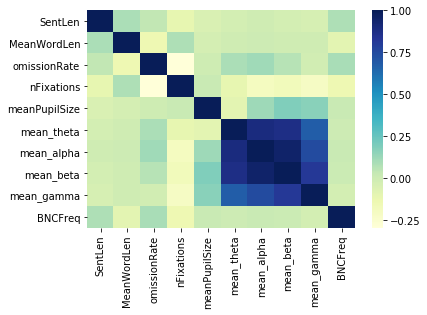

In [85]:
corr_mat(compute_allvals(sbjs_t2_eeg, features='EEG'), features='EEG', heatmap=True)

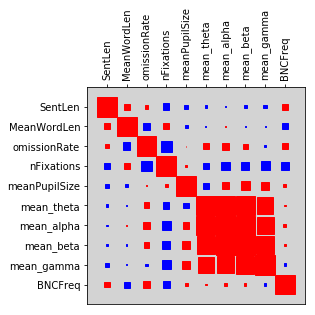

In [86]:
corr_mat(compute_allvals(sbjs_t2_eeg, features='EEG'), features='EEG', hinton_mat=True)

In [87]:
corr_mat(compute_allvals(sbjs_t3_eeg, features='EEG'), features='EEG', heatmap=False)

,SentLen,MeanWordLen,omissionRate,nFixations,meanPupilSize,mean_theta,mean_alpha,mean_beta,mean_gamma,BNCFreq
SentLen,1.000000,0.027612,0.213212,-0.081536,-0.046910,-0.002671,0.001347,-0.003183,-0.019947,-0.137217
MeanWordLen,0.027612,1.000000,-0.144142,0.126453,-0.008896,-0.001870,-0.001787,-0.002141,-0.003971,-0.259845
omissionRate,0.213212,-0.144142,1.000000,-0.319906,-0.109924,0.121435,0.009730,-0.046105,0.001639,-0.159095
nFixations,-0.081536,0.126453,-0.319906,1.000000,0.024687,-0.049730,-0.020729,-0.016385,-0.046280,-0.015669
meanPupilSize,-0.046910,-0.008896,-0.109924,0.024687,1.000000,0.025110,0.244429,0.271749,0.215363,0.011660
mean_theta,-0.002671,-0.001870,0.121435,-0.049730,0.025110,1.000000,0.886232,0.874468,0.770784,0.004163
mean_alpha,0.001347,-0.001787,0.009730,-0.020729,0.244429,0.886232,1.000000,0.963015,0.827144,0.004832
mean_beta,-0.003183,-0.002141,-0.046105,-0.016385,0.271749,0.874468,0.963015,1.000000,0.851141,0.009055
mean_gamma,-0.019947,-0.003971,0.001639,-0.046280,0.215363,0.770784,0.827144,0.851141,1.000000,0.012948
BNCFreq,-0.137217,-0.259845,-0.159095,-0.015669,0.011660,0.004163,0.004832,0.009055,0.012948,1.000000


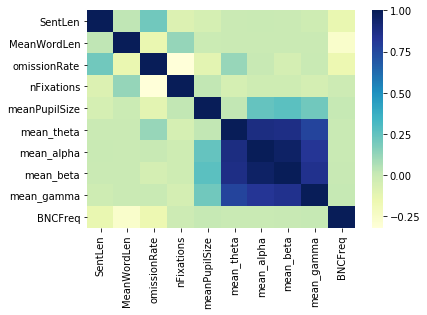

In [88]:
corr_mat(compute_allvals(sbjs_t3_eeg, features='EEG'), features='EEG', heatmap=True)

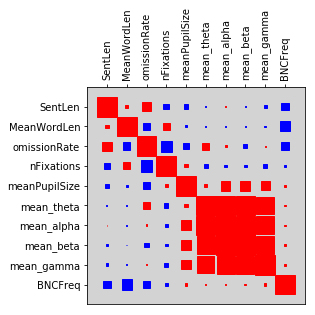

In [89]:
corr_mat(compute_allvals(sbjs_t3_eeg, features='EEG'), features='EEG', hinton_mat=True)

#### Mean EEG activity (theta) per sentence per subject

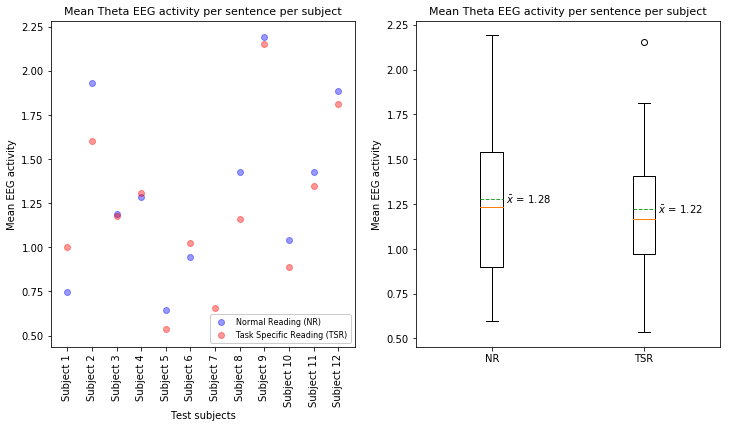

p-value: 0.0013328058722812408


In [90]:
plot_eeg(mean_theta_t2_m, mean_theta_t3_m, 'theta')
print("p-value:", randomsample_paired_ttest(mean_theta_t2, mean_theta_t3))

#### Mean EEG activity (alpha) per sentence per subject

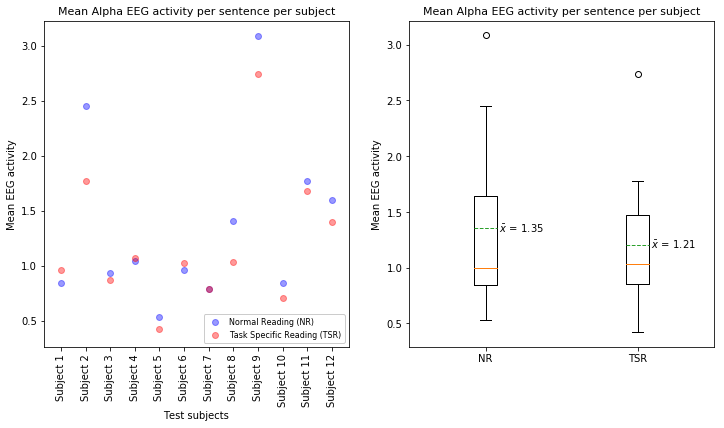

p-value: 5.549907498771231e-08


In [91]:
plot_eeg(mean_alpha_t2_m, mean_alpha_t3_m, 'alpha')
print("p-value:", randomsample_paired_ttest(mean_alpha_t2, mean_alpha_t3))

#### Mean EEG activity (beta) per sentence per subject

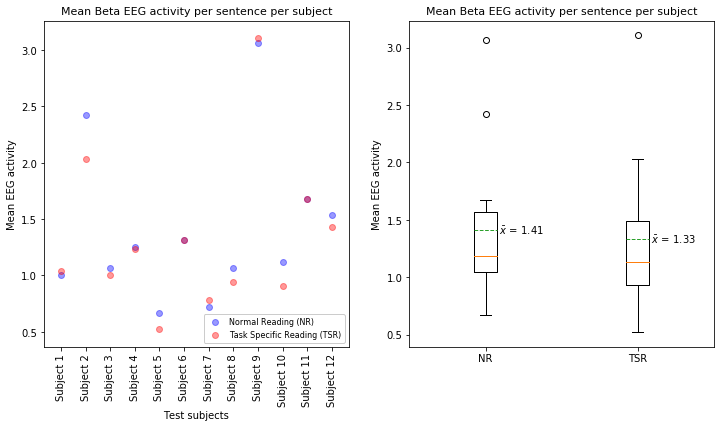

p-value: 0.01461865842905303


In [92]:
plot_eeg(mean_beta_t2_m, mean_beta_t3_m, 'beta')
print("p-value:", randomsample_paired_ttest(mean_beta_t2, mean_beta_t3))

#### Mean EEG activity (gamma) per sentence per subject

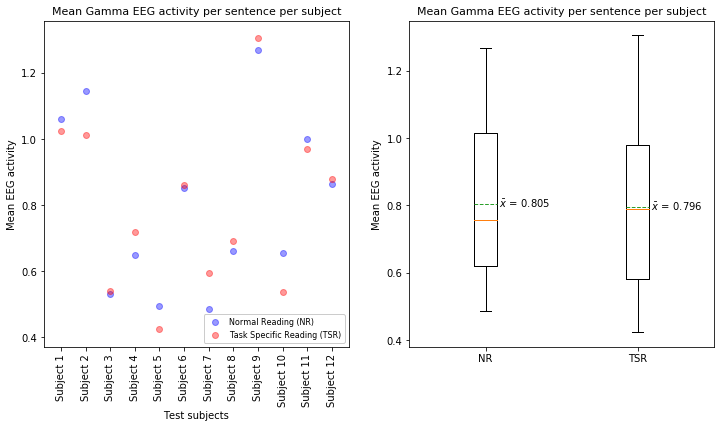

p-value: 0.7324363263156164


In [93]:
plot_eeg(mean_gamma_t2_m, mean_gamma_t3_m, 'gamma')
print("p-value:", randomsample_paired_ttest(mean_gamma_t2, mean_gamma_t3))